# Prelab 06: working with 2 channels and fit ranges

In Experiment 06 you will be taking two types of data for a circuit with a diode:
1. measuring the response of a diode to different DC biases
2. measuring the response of a diode to an AC voltage

While for objective 1, there is a simple (and pedagogically recommended) way to do this on the breadboard, and taking some data points manually, there is also a quick way using the function generator and both channels of the oscilloscope. In either case, you will likely need to adjust the range you fit, and we'll practice calling parts of an array here to make that simpler.

For objective 2, you will need to acquire both channel 1 and channel 2 on the oscilloscope. We'll practice plotting these together and even plotting one voltage vs. the other.

## Working with CH 1 and CH2 together

We'll start by loading some data from the RC circuit lab. This time, don't trim the data since we want to look at it like it was on the oscilloscope. 

First Channel 1 data, saved as `RCinput2.csv`:

In [ ]:
# import the  necessary libraries and rename them
import numpy as np
import array
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# LIST OF ALL INPUTS
###############################################################################

fname = 'file.csv' # file name containing your raw data

title='My Packed MicSig Data' # give your graph a title
output_name = 'file_packed.csv' # provide an output filename for the packed data

# choose the data range you want to examine
indexraw_min = 0
indexraw_max = 8000

# set y-scale to correspond to this range
yregion_min=0.
yregion_max=2.

# select an uncertainty type
# "default" uses the standard deviation of the selected flat region
# if standard deviation is unreasonably small and/or shows only digitization noise with single bit flips,
# set uncertainty type to "digital" to take the standard deviation of a boxcar defined by the max/min values
# or, set uncertainty type to "manual" and set a value for manualsigma
uncertainty = "default"
manualsigma = 0

npac=100 # define packing factor  npac

# trim data set range before output to .csv file
trim = 0 # default is 0 to save full dataset, set trim to 1 to trim the output data then give the range
trim_min=50 # start of trimmed data by packed index
trim_max=800 # end of trimmed data by packed index

###############################################################################
# READ IN DATA
###############################################################################

# read in data - the file is assumed to be in csv format (comma separated variables). 
#Files need to be specified with a full path OR they have to be saved in the same folder 
#as the script
data = np.loadtxt(fname, delimiter=',', comments='#',usecols=(3,4),skiprows=1)
#data = np.loadtxt(fname, delimiter=',',comments='#' )
# access the data columns and assign variables xraw and yraw
#generate  an array  xraw  which is the first  column  of  data.  Note the first column is 
#indexed as  zero.
xraw = data[:,0]
#generate  an array  yraw  which is the second  column  of  data  (index  1)
yraw = data[:,1]
#generate array containing index
indexraw=np.arange(len(xraw))

# plot data versus time and data versus index
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.scatter(xraw, yraw,marker='.')
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Voltage (V)')
ax1.set_title('My Raw MicSig Data')
ax2 = fig.add_subplot(122)
ax2.scatter(indexraw,yraw,marker='.')
ax2.set_xlabel('Index')
ax2.set_ylabel('Voltage (V)')
plt.show()

###############################################################################
# PLOT RESTRICTED INDEX RANGE OF FLAT DATA, CALCULATE UNCERTAINTY
# plots a restricted index range where the data is flat
# and calculates the standard deviation to assess the noise
###############################################################################

# change axis limits
plt.xlim(indexraw_min,indexraw_max)
plt.ylim(yregion_min,yregion_max)

# plot the data versus index
plt.scatter(indexraw,yraw,marker='.')

# This next command displays the index plot. 
plt.show()

#calculate and display the mean and standard deviation of the data that you have zoomed in on.
y_ave = np.mean(yraw[indexraw_min:indexraw_max])
y_std = np.std(yraw[indexraw_min:indexraw_max])
print('mean = ',y_ave)
print('standard deviation = ', y_std)

# display a histogram of the data
hist,bins = np.histogram(yraw[indexraw_min:indexraw_max],bins=20)
plt.bar(bins[:-1],hist,width=bins[1]-bins[0])
plt.ylim(0,1.2*np.max(hist))
plt.xlabel('y_raw (Volts)')
plt.ylabel('Number of occurences')
plt.show()

###############################################################################
# PACK AND TRIM DATA
###############################################################################

#define a function  to pack the data
def pack(A,p):
  # A is an array, and p is the packing factor
  B = np.zeros(len(A)//p)
  i = 1
  while i-1<len(B):
    B[i-1] = np.mean(A[p*(i-1):p*i])
    i += 1
  return B
# pack the data
x=pack(xraw,npac)
y=pack(yraw,npac)

#create a vector that also has the integer index (index = 0,1,2 ... length-1)
length=len(x)
#print(length)
index = np.arange(length)

#create a vector that contains fixed uncertainty for x values (in this case set to zero
sigmax = [0]*length
#print(sigmax)

#Create a vector that contains uncertainty of averaged y values. 
#sigmayraw is your estimate of the uncertainty in individual raw data points

#Here it is taking that value from your previous statistics code 
#If the data sampled shows only a small amount of digitization noise, and the standard deviation is unreasonably small, 
#select "digital" above to take the stdev of a boxcar of the width of the digitization
#If you think the standard deviation of your data is an underestimate of the uncertainty,
#you can also enter a value by hand - just change the line that defines simayraw

if uncertainty == "digital":
    sigmayraw = 0.5 * (np.max(yraw[indexraw_min:indexraw_max])-np.min(yraw[indexraw_min:indexraw_max]))/np.sqrt(3)
    print("digital uncertainty used:",sigmayraw)
elif uncertainty == "manual":
    sigmayraw = manualsigma
    print("manually specified uncertainty used:",sigmayraw)
else:
    sigmayraw = y_std
    

#sigmaymean is the uncertainty of y after averaging npac points together
#sigmay is an array of uncertainties, all of the same value as sigmaymean
sigmaymean = sigmayraw/np.sqrt(npac)
sigmay = [sigmaymean]*length

print('packing is done by averaging', npac, 'data points')

if trim == 1:
    index_min=trim_min
    index_max=trim_max
    print('packed data has been trimmed from ', index_min, 'to ', index_max)
else:
    index_min=0
    index_max=length
    print('packed data contains full data set')

# plot the trimmed data versus index
plt.errorbar(index,y,yerr=sigmay,marker='.',linestyle='')
## marker='o' : use markers to indicate each data point (x_1,y_1),(x_2,y_2)
## linestyle= '' : no line is drawn to connect the data points
## linestyle= '-' : a line is drawn to connect the data points

# change axis limits
plt.xlim(index_min,index_max)

# add axis labels
plt.title('Packed and Trimmed Data For Storage')
plt.xlabel('Index')
plt.ylabel('Voltage (V)')
plt.show()

# Create Array and output as CSV file in four-column format with two-row headers

header = [np.array(['time','u[time]','Voltage','u[Voltage]']), 
np.array(['(sec)','(sec)','(V)','(V)'])]
d1 = [x[index_min:index_max] , sigmax[index_min:index_max] , y[index_min:index_max] , sigmay[index_min:index_max]]
d1_a = np.array(d1)
df = pd.DataFrame(np.transpose(d1_a), columns=header )   
    
# print(df)


###############################################################################
# SAVE DATA TO FILE
###############################################################################

csv_data = df.to_csv(output_name, index = False)
print('Packed Data Stored in ', output_name)

Then Channel 2, saved as `RCdecayVC2.csv`:

In [ ]:
# import the  necessary libraries and rename them
import numpy as np
import array
import pandas as pd
import matplotlib.pyplot as plt

###############################################################################
# LIST OF ALL INPUTS
###############################################################################

fname = 'file2.csv' # file name containing your raw data

title='My Packed MicSig Data' # give your graph a title
output_name = 'file2_packed.csv' # provide an output filename for the packed data

# choose the data range you want to examine
indexraw_min = 0
indexraw_max = 6000

# set y-scale to correspond to this range
yregion_min=0.
yregion_max=2.

# select an uncertainty type
# "default" uses the standard deviation of the selected flat region
# if standard deviation is unreasonably small and/or shows only digitization noise with single bit flips,
# set uncertainty type to "digital" to take the standard deviation of a boxcar defined by the max/min values
# or, set uncertainty type to "manual" and set a value for manualsigma
uncertainty = "default"
manualsigma = 0

npac=100 # define packing factor  npac

# trim data set range before output to .csv file
trim = 0 # default is 0 to save full dataset, set trim to 1 to trim the output data then give the range
trim_min=50 # start of trimmed data by packed index
trim_max=800 # end of trimmed data by packed index

###############################################################################
# READ IN DATA
###############################################################################

# read in data - the file is assumed to be in csv format (comma separated variables). 
#Files need to be specified with a full path OR they have to be saved in the same folder 
#as the script
data = np.loadtxt(fname, delimiter=',', comments='#',usecols=(3,4),skiprows=1)
#data = np.loadtxt(fname, delimiter=',',comments='#' )
# access the data columns and assign variables xraw and yraw
#generate  an array  xraw  which is the first  column  of  data.  Note the first column is 
#indexed as  zero.
xraw = data[:,0]
#generate  an array  yraw  which is the second  column  of  data  (index  1)
yraw = data[:,1]
#generate array containing index
indexraw=np.arange(len(xraw))

# plot data versus time and data versus index
fig = plt.figure(figsize=(12,5))
ax1 = fig.add_subplot(121)
ax1.scatter(xraw, yraw,marker='.')
ax1.set_xlabel('Time (sec)')
ax1.set_ylabel('Voltage (V)')
ax1.set_title('My Raw MicSig Data')
ax2 = fig.add_subplot(122)
ax2.scatter(indexraw,yraw,marker='.')
ax2.set_xlabel('Index')
ax2.set_ylabel('Voltage (V)')
plt.show()

###############################################################################
# PLOT RESTRICTED INDEX RANGE OF FLAT DATA, CALCULATE UNCERTAINTY
# plots a restricted index range where the data is flat
# and calculates the standard deviation to assess the noise
###############################################################################

# change axis limits
plt.xlim(indexraw_min,indexraw_max)
plt.ylim(yregion_min,yregion_max)

# plot the data versus index
plt.scatter(indexraw,yraw,marker='.')

# This next command displays the index plot. 
plt.show()

#calculate and display the mean and standard deviation of the data that you have zoomed in on.
y_ave = np.mean(yraw[indexraw_min:indexraw_max])
y_std = np.std(yraw[indexraw_min:indexraw_max])
print('mean = ',y_ave)
print('standard deviation = ', y_std)

# display a histogram of the data
hist,bins = np.histogram(yraw[indexraw_min:indexraw_max],bins=20)
plt.bar(bins[:-1],hist,width=bins[1]-bins[0])
plt.ylim(0,1.2*np.max(hist))
plt.xlabel('y_raw (Volts)')
plt.ylabel('Number of occurences')
plt.show()

###############################################################################
# PACK AND TRIM DATA
###############################################################################

#define a function  to pack the data
def pack(A,p):
  # A is an array, and p is the packing factor
  B = np.zeros(len(A)//p)
  i = 1
  while i-1<len(B):
    B[i-1] = np.mean(A[p*(i-1):p*i])
    i += 1
  return B
# pack the data
x=pack(xraw,npac)
y=pack(yraw,npac)

#create a vector that also has the integer index (index = 0,1,2 ... length-1)
length=len(x)
#print(length)
index = np.arange(length)

#create a vector that contains fixed uncertainty for x values (in this case set to zero
sigmax = [0]*length
#print(sigmax)

#Create a vector that contains uncertainty of averaged y values. 
#sigmayraw is your estimate of the uncertainty in individual raw data points

#Here it is taking that value from your previous statistics code 
#If the data sampled shows only a small amount of digitization noise, and the standard deviation is unreasonably small, 
#select "digital" above to take the stdev of a boxcar of the width of the digitization
#If you think the standard deviation of your data is an underestimate of the uncertainty,
#you can also enter a value by hand - just change the line that defines simayraw

if uncertainty == "digital":
    sigmayraw = 0.5 * (np.max(yraw[indexraw_min:indexraw_max])-np.min(yraw[indexraw_min:indexraw_max]))/np.sqrt(3)
    print("digital uncertainty used:",sigmayraw)
elif uncertainty == "manual":
    sigmayraw = manualsigma
    print("manually specified uncertainty used:",sigmayraw)
else:
    sigmayraw = y_std
    

#sigmaymean is the uncertainty of y after averaging npac points together
#sigmay is an array of uncertainties, all of the same value as sigmaymean
sigmaymean = sigmayraw/np.sqrt(npac)
sigmay = [sigmaymean]*length

print('packing is done by averaging', npac, 'data points')

if trim == 1:
    index_min=trim_min
    index_max=trim_max
    print('packed data has been trimmed from ', index_min, 'to ', index_max)
else:
    index_min=0
    index_max=length
    print('packed data contains full data set')

# plot the trimmed data versus index
plt.errorbar(index,y,yerr=sigmay,marker='.',linestyle='')
## marker='o' : use markers to indicate each data point (x_1,y_1),(x_2,y_2)
## linestyle= '' : no line is drawn to connect the data points
## linestyle= '-' : a line is drawn to connect the data points

# change axis limits
plt.xlim(index_min,index_max)

# add axis labels
plt.title('Packed and Trimmed Data For Storage')
plt.xlabel('Index')
plt.ylabel('Voltage (V)')
plt.show()

# Create Array and output as CSV file in four-column format with two-row headers

header = [np.array(['time','u[time]','Voltage','u[Voltage]']), 
np.array(['(sec)','(sec)','(V)','(V)'])]
d1 = [x[index_min:index_max] , sigmax[index_min:index_max] , y[index_min:index_max] , sigmay[index_min:index_max]]
d1_a = np.array(d1)
df = pd.DataFrame(np.transpose(d1_a), columns=header )   
    
# print(df)


###############################################################################
# SAVE DATA TO FILE
###############################################################################

csv_data = df.to_csv(output_name, index = False)
print('Packed Data Stored in ', output_name)

### Plotting CH1 and CH2 together

The following plotting section has been modified to take 2 files and plot them on the same axes. The only change from similar code we used before is the addition of an extra file name on line 9 `fname2`, an corresponding data variable to read the data into on line 16 `dataCH2` (and `data` has been changed to `dataCH1`), and an extra block where the variables are read in on lines 24-27 (now we have `x1`, `x1_sigma`, `y1`, `y1_sigma` and the corresponding set for the 2nd data set).

Put the filenames you used for the packed data above for CH1 as `fname1` and CH2 as `fname2`.

In [ ]:
# import the  library numpy  and rename it  np
import numpy as np
import array

# import the library matplotlib and rename it plot
import matplotlib.pyplot as plt
# Name of the data file
fname1 = "file1_packed.csv"
fname2 = "file2_packed.csv"

# This block reads in data - the file is assumed to be in csv format (comma separated variables). 
# Files need to be specified with a full path OR they have to be saved in the same folder as the script
# 
# load the file fname and skip the first 'skiprows' rows
dataCH1 = np.loadtxt(fname1, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)
dataCH2 = np.loadtxt(fname2, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)

# Assign the data file columns to variables for later use
x1 = dataCH1[:, 0]
x1_sigma = dataCH1[:, 1]
y1 = dataCH1[:, 2]
y1_sigma = dataCH1[:, 3]

x2 = dataCH2[:, 0]
x2_sigma = dataCH2[:, 1]
y2 = dataCH2[:, 2]
y2_sigma = dataCH2[:, 3]

#print(len(x), len(y), len(y_sigma))

# This block creates a plot

plt.errorbar(x1,y1,xerr=x1_sigma,yerr=y1_sigma,marker='.',linestyle='-',label="CH 1")
plt.errorbar(x2,y2,xerr=x2_sigma,yerr=y2_sigma,marker='.',linestyle='-',label="CH 2")
plt.legend()
plt.xlabel('time [s]')
plt.ylabel('V [V]')
plt.title(' ')
plt.show()

This *should* look very much like you would expect an oscilloscope trace to look with both channels displayed. You can adjust the axis labels and title in the lines 36-38 near the bottom of the block above.

### Lissajous figures or "xy" plots

Something we didn't do with the RC circuit is a "Lissajous" figure, which directly shows the amplitude and phase relationshp between the input and output voltages. This is kind of fun, so let's try it now.

Copy the block of code above, but instead of plotting y vs. x, plot the y varaibles (voltage) for CH1 vs. CH2. You can do this either by modifying where you assign the `dataCH1` and `dataCH2` columns to variables, or where you choose which variables to plot.

In [ ]:
# import the  library numpy  and rename it  np
import numpy as np
import array

# import the library matplotlib and rename it plot
import matplotlib.pyplot as plt
# Name of the data file
fname1 = "file1_packed.csv"
fname2 = "file2_packed.csv"

# This block reads in data - the file is assumed to be in csv format (comma separated variables). 
# Files need to be specified with a full path OR they have to be saved in the same folder as the script
# 
# load the file fname and skip the first 'skiprows' rows
dataCH1 = np.loadtxt(fname1, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)
dataCH2 = np.loadtxt(fname2, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)

# Assign the data file columns to variables for later use
x1 = dataCH1[:, 0]
x1_sigma = dataCH1[:, 1]
y1 = dataCH1[:, 2]
y1_sigma = dataCH1[:, 3]

x2 = dataCH2[:, 0]
x2_sigma = dataCH2[:, 1]
y2 = dataCH2[:, 2]
y2_sigma = dataCH2[:, 3]

#print(len(x), len(y), len(y_sigma))

# This block creates a plot

plt.errorbar(y1,y2,xerr=y1_sigma,yerr=y2_sigma,marker='.',linestyle='-',label="")
plt.xlabel('CH1 V [V]')
plt.ylabel('CH2 V [V]')
plt.title(' ')
plt.show()

To be a proper "Lissajous" figure, the input should be a sine wave, but already you get the idea that it forms a loop.

Because this can be such a useful thing to visualize, oscilloscopes usually have this function (to plot one channel vs. another) built in. Indeed our tablet scopes have this as well in the pulldown menu options, and here is what a diode response looks like (this is a Ge diode, with a threshold voltage ~0.3V)! There is no phase shift, so no loop, but we can trace out Vin vs. Vout pretty clearly and easily this way (but no, it won't save this plot directly, you need to still save CH1 and CH2 vs. time and then plot them like we did above). 

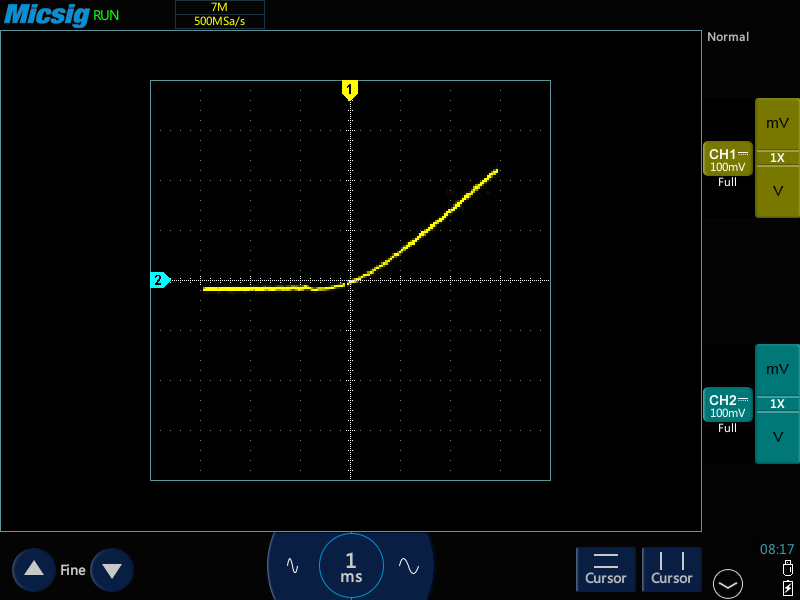

## Selecting data from an array

We've mostly been having you truncate your data in the "data pack and trim" step, but if you're adjusting the fit range a lot, this is a bit inefficient. Instead, we can call a specific subset of the array indicies when we assign the data we've read in to the variables we're using for fitting, which happens on lines 65-67 below.

First let's practice calling a subset of an array. The cell block below will create an array of 10 1's followed by 10 2's

In [ ]:
A=np.ones(10)
B=np.ones(10)*2
C=np.append(A,B)
print(C)

Now, let's say we only want the middle 10 digits (so still half 1's and half 2's), we can make a new variable `D` by assigning a subset of `C` to it: `D=C[5:15]`

In [ ]:
D=C[5:15]
print(D)

This works similarly with 2-dimensional arrays. You may have noticed when we read in the data we specify `x=data[:,0]`, which just says all elements in the first dimension, and only the 0th element in the 2nd dimension.

Use the decay data above and fit the exponential to the relevant segment by changing the range on lines 65-67 (not by going back to pack and trim!).

Note that since you need to specify the same range for all 3 variables `x`, `y`, and `y_sigma`, you could define a new fit range variable somewhere above to set this conveniently!

In [ ]:
# Load python packages
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

###############################################################################
# DEFINED FITTING FUNCTIONS
###############################################################################

def sine_func(x, amplitude, freq, phase):
    return amplitude * np.sin(2.0 * np.pi * freq * x + phase)

def offset_sine_func(x, amplitude, freq, phase, offset):
    return (amplitude * np.sin(2.0 * np.pi * freq * x + phase)) + offset

def exponential_func(x, amplitude, tau, voffset):
    return amplitude * np.exp(x/(-1.0*tau)) + voffset

def ringdown_function(x, amplitude, tau, resonantf, phase):
    return amplitude * np.exp(-x/tau) * np.cos(2.0*np.pi * resonantf * x + phase)

def linear_func(x, slope, intercept):
    return slope * x + intercept

def RCresp_func(x, tau, V0, voffset):
    return V0/(np.sqrt(1+(2*np.pi*tau*x)**2)) + voffset

def LRCresp_func(x, f0, Vin, gamma):
    return Vin/(np.sqrt(1+(2*np.pi/(gamma*x))**2*(x**2-f0**2)**2))

###############################################################################
# LIST OF ALL INPUTS
###############################################################################

# Name of the data file
fname = "file2_packed.csv"

# Names and units of data columns from fname
x_name = "Time"
x_units = "s"
y_name = "Voltage"
y_units = "V"

# Modify to change the fitting function, parameter names and to set initial parameter guesses
fit_function = exponential_func
param_names = ("amplitude", "tau", "voffset")
guesses = (1.0, 1e-6, 0.0)

# Flags for optional features
show_covariance_matrix = False
set_xy_boundaries = False
lower_x = -0.01 # these values ignored if set_xy_boundaries = False
upper_x = 0.01
lower_y = -1
upper_y = 1

###############################################################################
# LOAD DATA
###############################################################################

# load the file fname and skip the first 'skiprows' rows
data = np.loadtxt(fname, delimiter=",", comments="#", usecols=(0, 1, 2, 3), skiprows=2)

# Assign the data file columns to variables for later use
x = data[:, 0]
y = data[:, 2]
y_sigma = data[:, 3]

###############################################################################
# INITIAL PLOT OF THE DATA
###############################################################################

# Define 500 points spanning the range of the x-data; for plotting smooth curves
xtheory = np.linspace(min(x), max(x), 500)

# Compare the guessed curve to the data for visual reference
y_guess = fit_function(xtheory, *guesses)
plt.errorbar(x, y, yerr=y_sigma, marker=".", linestyle="", label="Measured data")
plt.plot(
    xtheory,
    y_guess,
    marker="",
    linestyle="-",
    linewidth=1,
    color="g",
    label="Initial parameter guesses",
)
plt.xlabel(f"{x_name} [{x_units}]")
plt.ylabel(f"{y_name} [{y_units}]")
plt.title(r"Comparison between the data and the intial parameter guesses")
plt.legend(loc="best", numpoints=1)
plt.show()

# calculate the value of the model at each of the x-values of the data set
y_fit = fit_function(x, *guesses)

# Residuals are the difference between the data and theory
residual = y - y_fit

# Plot the residuals
plt.errorbar(x, residual, yerr=y_sigma, marker=".", linestyle="", label="residuals")
plt.xlabel(f"{x_name} [{x_units}]")
plt.ylabel(f"Residual y-y_fit [{y_units}]")
plt.title("Residuals using initial parameter guesses")
plt.show()

###############################################################################
# PERFORM THE FIT AND PRINT RESULTS
###############################################################################

# Use curve_fit to perform the fit
# fit_function: defined above to choose a specific fitting function 
# fit_params: holds the resulting fit parameters
# fit_cov: the covariance matrix between all the parameters
#          (used to extract fitting parameter uncertanties)
# maxfev=10**5: maximum number of fitting procedure iterations before giving up
# absolute_sigma=True: uncertainties are treated as absolute (not relative)
fit_params, fit_cov = curve_fit(
    fit_function, x, y, sigma=y_sigma, 
    p0=guesses,absolute_sigma=True, maxfev=10**5)

# Define the function that calculates chi-squared
def chi_square(fit_parameters, x, y, sigma):
    dof = len(x) - len(fit_params)
    return np.sum((y - fit_function(x, *fit_parameters)) ** 2 / sigma**2)/dof

# Calculate and print reduced chi-squared
chi2 = chi_square(fit_params, x, y, y_sigma)
print("Chi-squared = ", chi2)

# Calculate the uncertainties in the fit parameters
fit_params_error = np.sqrt(np.diag(fit_cov))

# Print the fit parameters with uncertianties
print("\nFit parameters:")
for i in range(len(fit_params)):
    print(f"   {param_names[i]} = {fit_params[i]:.3e} ± {fit_params_error[i]:.3e}")
print("\n")

# (Optional) Print the covariance between all variables
if show_covariance_matrix:
    print("Covariance between fit parameters:")
    for i, fit_covariance in enumerate(fit_cov):
        for j in range(i+1,len(fit_covariance)):
            print(f"   {param_names[i]} and {param_names[j]}: {fit_cov[i,j]:.3e}")
    print("\n")

# residual is the difference between the data and model
x_fitfunc = np.linspace(min(x), max(x), 500) # uses fine mesh to plot the function smoothly
y_fitfunc = fit_function(x_fitfunc, *fit_params)
y_fit = fit_function(x, *fit_params) # uses x values from data
residual = y-y_fit

###############################################################################
# PRODUCE A MULTIPANEL PLOT, WITH SCATTER PLOT, RESIDUALS AND RESIDUALS HISTOGRAM
###############################################################################

# The size of the canvas
fig = plt.figure(figsize=(7,15))

# The scatter plot
ax1 = fig.add_subplot(311)
ax1.errorbar(x,y,yerr=y_sigma,marker='.',linestyle='',label="Measured data")
ax1.plot(x_fitfunc, y_fitfunc, marker="", linestyle="-", linewidth=2,color="r", label="Fit")
ax1.set_xlabel(f"{x_name} [{x_units}]")
ax1.set_ylabel(f"{y_name} [{y_units}]")
ax1.set_title('Best Fit of Function to Data')

# (Optional) set the x and y boundaries of your plot
if set_xy_boundaries:
    plt.xlim(lower_x,upper_x)
    plt.ylim(lower_y,upper_y)
# Show the legend. loc='best' places it where the date are least obstructed
ax1.legend(loc='best',numpoints=1)

# The residuals plot
ax2 = fig.add_subplot(312)
ax2.errorbar(x, residual, yerr=y_sigma,marker='.', linestyle='', label="Residual (y-y_fit)")
ax2.hlines(0,np.min(x),np.max(x),lw=2,alpha=0.8)
ax2.set_xlabel(f"{x_name} [{x_units}]")
ax2.set_ylabel(f"y-y_fit [{y_units}]")
ax2.set_title('Residuals for the Best Fit')
ax2.legend(loc='best',numpoints=1)

# Histogram of the residuals
ax3 = fig.add_subplot(313)
hist,bins = np.histogram(residual,bins=30)
ax3.bar(bins[:-1],hist,width=bins[1]-bins[0])
ax3.set_ylim(0,1.2*np.max(hist))
ax3.set_xlabel(f"y-y_fit [{y_units}]")
ax3.set_ylabel('Number of occurences')
ax3.set_title('Histogram of the Residuals')

# Save a copy of the figure as a png 
plt.savefig('FittingResults.png')

# Show the plot
plt.show()

## Prepare notebook

From here on, we won't be providing a template for your notebooks. Spend some time setting up your own template for this week's lab with some standard headers, and by looking at the instructions to anticipate some of the sections and code you might need.